In [1]:
import os
import math

import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {torch.cuda.get_device_name(device)}")

Using device: NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
# perform transformation on the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [6]:
# Adjust according to your GPU VRAM
batch_size = 64

In [7]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
print(f"Total training images: {len(train_dataset)}")

Total training images: 60000


In [8]:
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers = 8, pin_memory=True)
print(f"Total test images: {len(test_dataset)}")

Total test images: 10000


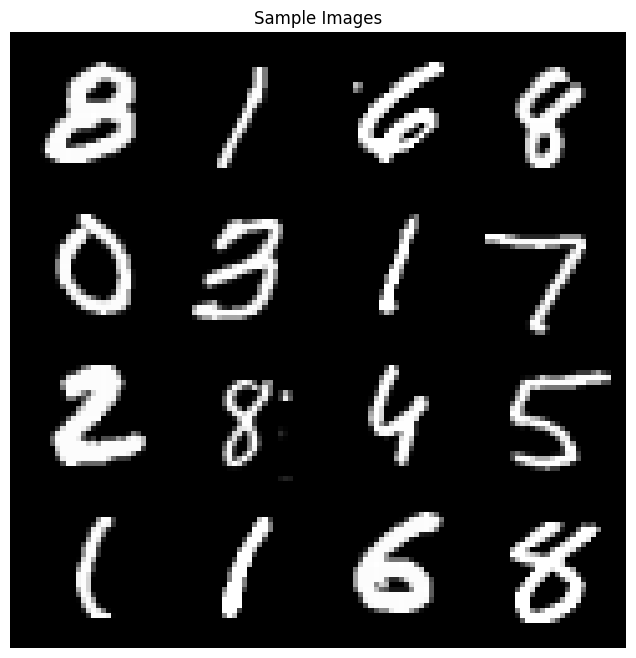

In [12]:
from torchvision.utils import make_grid

# Visualize some training images
def visualize_images(dataloader, num_images=16):
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]

    grid_img = make_grid(images, nrow=4, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.title('Sample Images')
    plt.axis('off')
    plt.show()

visualize_images(train_dataloader)

Before we train our diffusion model, we train a simple MLP which will help us classify the digits into numbers.
This is a relatively small and simpler model to train. So it shouldn't take more than 15 minutes to train.

This MLP takes 28 by 28 image input as a grid and classifies them to digits between 0-9

In [14]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.fc(x)

In [15]:
from torch.optim import Adam

# Load the model to GPU
cls_model = DigitClassifier().to(device)
cls_optim = Adam(cls_model.parameters(), lr=1e-4)
cls_loss = nn.CrossEntropyLoss()

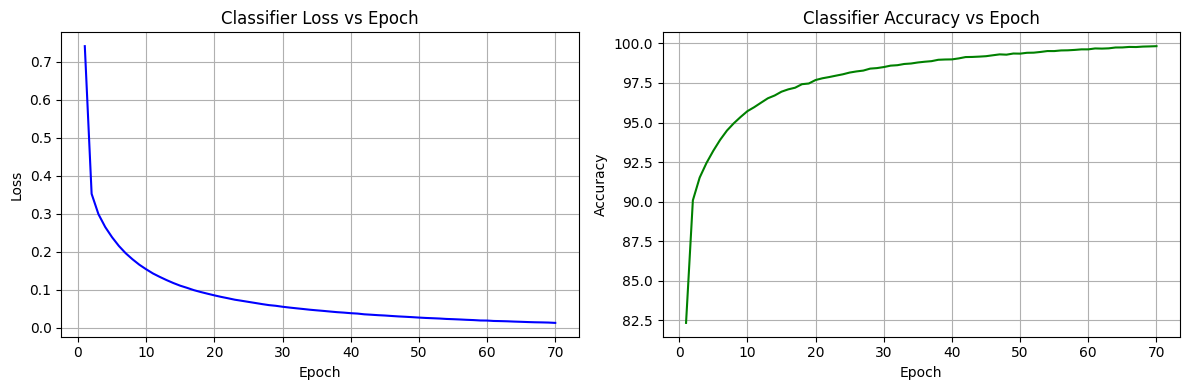

In [16]:
epochs = 70

start_epoch = 0

losses_per_epoch = []
accuracies_per_epoch = []

# Begin the training loop
print("Starting classifier training")
for epoch in range(start_epoch, epochs):
    cls_model.train()
    pbar = tqdm.tqdm(train_dataloader)
    
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for step, (x, labels) in enumerate(pbar):
        x = x.to(device)
        labels = labels.to(device)
        batch_size = x.shape[0]     # should be 64

        pred_labels = cls_model(x)  # Get the predictions
        loss = cls_loss(pred_labels, labels)    # Calculate the loss

        cls_optim.zero_grad()   # set gradients to 0 explicitly
        loss.backward()     # perform the backpropagation

        cls_optim.step()    # update the parameters

        _, predicted = torch.max(pred_labels, 1)    # Get predicted class indices
        correct_preds += (predicted == labels).sum().item()
        total_preds += batch_size
        total_loss += loss.item()

        accuracy = correct_preds * 100 / total_preds
        
        pbar.set_description(f"Classifier Loss: {loss.item():0.3f} | Accuracy: {accuracy:0.3f}%")

    if total_preds > 0:
        avg_loss = total_loss / (step + 1)  # Adjust for possible early break
        accuracy = correct_preds / total_preds * 100
        losses_per_epoch.append(avg_loss)
        accuracies_per_epoch.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs} | Average Loss: {avg_loss:.6f} | Accuracy: {accuracy:.2f}%")
    else:
        print(f"Epoch {epoch+1}/{epochs} | No valid batches processed. Check data loading.")
        losses_per_epoch.append(float('nan'))
        accuracies_per_epoch.append(0.0)


    # Plot the graphs
    clear_output(wait=True)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), losses_per_epoch, label='Loss', color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Classifier Loss vs Epoch")
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), accuracies_per_epoch, label='Accuracy (%)', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Classifier Accuracy vs Epoch")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Test Accuracy on batch: 100.00%


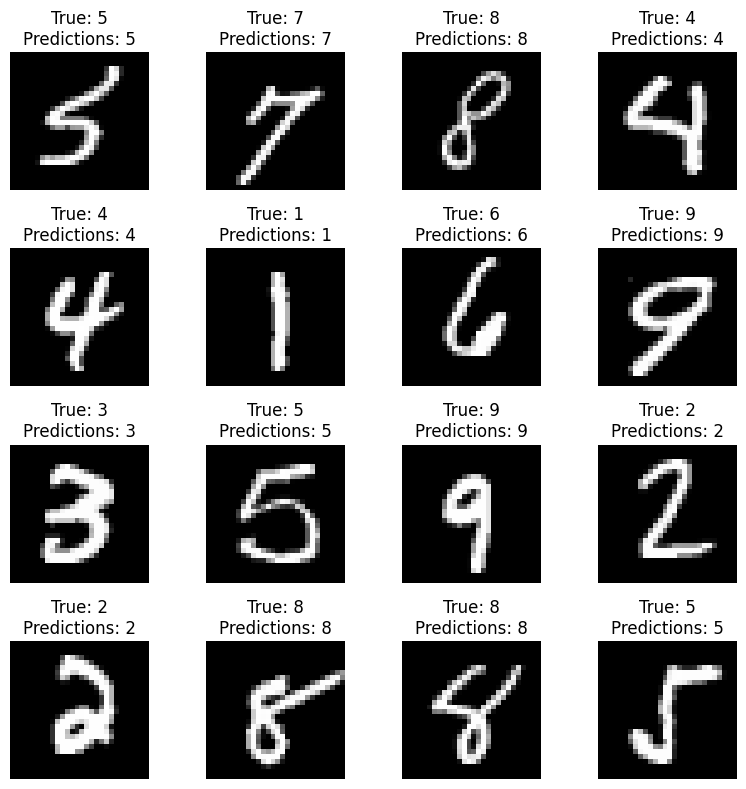

In [18]:
# Testing the classifier 
cls_model.eval()    # Set the model to evaluation mode

with torch.no_grad():
    correct_prds = 0

    total_prds = 0
    
    for _, (imgs, labels) in enumerate(test_dataloader):
        imgs = imgs.to(device)

        output = cls_model(imgs)

        _, predictions = torch.max(output, 1)

        predictions = predictions.cpu()

        for items in zip(predictions,labels):
            if items[0]!=items[1]:
                continue
            else:
                correct_prds += 1

            total_prds += 1

    accuracy = correct_prds * 100 / total_prds
    
    print(f"Test Accuracy on batch: {accuracy:.2f}%")

imgs = imgs.cpu()

fig, axes = plt.subplots(4,4, figsize=(8,8))
axes = axes.ravel()

for idx in range(16):
    ax = axes[idx]
    img = imgs[idx].numpy().squeeze()  # (1, 28, 28) -> (28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {labels[idx].item()}\nPredictions: {predictions[idx].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [29]:
# Diffusion schedules
T = 1000
beta_start, beta_end = 1e-4, 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)

In [30]:
# Forward diffusion function
def forward_diffusion_sample(x_0, t, device=device):
    noise = torch.randn_like(x_0).to(device)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t][:, None, None, None]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
    x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
    return x_t, noise

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# --- TIME EMBEDDING ---
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb  # [B, dim]

# --- RESIDUAL BLOCK ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super().__init__()
        num_groups1 = min(8, in_channels) if in_channels % 8 != 0 else 8
        self.norm1 = nn.GroupNorm(num_groups1, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        num_groups2 = min(8, out_channels) if out_channels % 8 != 0 else 8
        self.norm2 = nn.GroupNorm(num_groups2, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.time_proj = nn.Linear(time_dim, out_channels)
        self.skip = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.conv1(F.silu(self.norm1(x)))
        time_emb = self.time_proj(t)[:, :, None, None]
        h = h + time_emb
        h = self.conv2(F.silu(self.norm2(h)))
        return h + self.skip(x)

# --- ATTENTION BLOCK (Optional mid-layer) ---
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h).reshape(B, 3, C, H * W)
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]
        attn = torch.softmax((q @ k.transpose(-1, -2)) / (C ** 0.5), dim=-1)
        h = (attn @ v).reshape(B, C, H, W)
        return x + self.proj(h)

# --- FULL U-NET ---
class DiffusionUNet(nn.Module):
    def __init__(self, img_channels=1, base_channels=64, time_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )

        # Encoder
        self.enc1 = ResidualBlock(img_channels, base_channels, time_dim)
        self.enc2 = ResidualBlock(base_channels, base_channels * 2, time_dim)
        self.enc3 = ResidualBlock(base_channels * 2, base_channels * 4, time_dim)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            ResidualBlock(base_channels * 4, base_channels * 4, time_dim),
            SelfAttention(base_channels * 4),  # optional
            ResidualBlock(base_channels * 4, base_channels * 4, time_dim)
        )

        # Decoder
        self.dec3 = ResidualBlock(base_channels * 4, base_channels * 2, time_dim)
        self.dec2 = ResidualBlock(base_channels * 2, base_channels, time_dim)
        self.dec1 = ResidualBlock(base_channels, base_channels, time_dim)

        # Final
        self.final = nn.Conv2d(base_channels, img_channels, 1)

        # Down/Up-sampling
        self.down = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)

        # Encoder
        e1 = self.enc1(x, t_emb)
        e2 = self.enc2(self.down(e1), t_emb)
        e3 = self.enc3(self.down(e2), t_emb)

        # Bottleneck
        b = self.bottleneck(self.down(e3))

        # Decoder
        d3 = self.up(b)
        d3 = self.dec3(d3 + e3, t_emb)
        d2 = self.up(d3)
        d2 = self.dec2(d2 + e2, t_emb)
        d1 = self.up(d2)
        d1 = self.dec1(d1 + e1, t_emb)

        return self.final(d1)  # raw noise prediction (no sigmoid)


In [26]:
model = DiffusionUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
mse = nn.MSELoss()

In [31]:

epochs = 200

# Load pre-trained classifier
classifier = DigitClassifier().to(device)
classifier.eval()  # Freeze classifier, no training

start_epoch = 0
losses_per_epoch = []
psnrs_per_epoch = []
accuracies_per_epoch = []

In [28]:
# Using FID as a metric
from torcheval.metrics.image import FrechetInceptionDistance

fid = FrechetInceptionDistance(device=device)

In [32]:
from warnings import filterwarnings
filterwarnings("ignore")

In [33]:
print("Starting diffusion training")
for epoch in range(start_epoch, epoch):
    print(f"\nEpoch {epoch+1}/{epochs}")
    pbar = tqdm.tqdm(train_dataloader)
    total_loss = 0
    step_count = 0

    model.train()
    for step, (imgs, labels) in enumerate(pbar):
        imgs = imgs.to(device)
        labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)
        batch_size = imgs.shape[0]

        t = torch.randint(0, T, (batch_size,), device=device).long()

        x_t, noise = forward_diffusion_sample(x, t)
        if x_t.shape != noise.shape or x_t.shape[1:] != (1, 28, 28):
            raise ValueError(f"Shape mismatch: x_t {x_t.shape}, noise {noise.shape}")

        noise_pred = model(x_t, t.float(), labels_one_hot)
        if noise_pred.shape != noise.shape:
            raise ValueError(f"Shape mismatch: noise_pred {noise_pred.shape}, noise {noise.shape}")
        
        loss = mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        alpha_bar = sqrt_alphas_cumprod[t][:, None, None, None]
        one_minus_alpha_bar = sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        x0_pred = (x_t - one_minus_alpha_bar * noise_pred) / alpha_bar
        x0_pred = torch.clamp(x0_pred, -1, 1)

        total_loss += loss.item()
        step_count += 1
        pbar.set_description(f"Loss: {loss.item():0.4f}")

    if step_count > 0:
        avg_loss = total_loss / step_count
        losses_per_epoch.append(avg_loss)
        print(f"Average loss: {avg_loss:0.6f}")
    else:
        print(f"Epoch {epoch+1}/{epochs} | No valid batches processed. Check data or reduce batch size.")
        losses_per_epoch.append(float('nan'))

    # Compute FID score every 10 epochs or at the end
    if epoch % 10 == 0 or epoch == epochs-1:
        print("Computing FID score...")
        model.eval()
        fid.reset()
        n_samples = 1000
        batch_size_fid = 64

        # Match label distribution from real data
        real_labels = []
        for _, labels in train_dataloader:
            real_labels.extend(labels.numpy())
            if len(real_labels) > n_samples:
                break
        real_labels = np.array(real_labels)[:n_samples]
        label_dist = np.bincount(real_labels, minlength=10) / len(real_labels)
        labels_all = np.random.choice(10, n_samples, p=label_dist)
        labels_all = torch.from_numpy(labels_all).to(device)
        labels_one_hot_all = F.one_hot(labels_all, num_classes=10).float()

        x_gen_all = []
        for i in range(0, n_samples, batch_size_fid):
            batch_labels = labels_one_hot_all[i:i + batch_size_fid]
            batch_size = min(batch_size_fid, n_samples - i)
            x_gen = torch.randn((batch_size, 1, 28, 28)).to(device)
            for t in reversed(range(0, T)):
                if t % 100 == 0:
                    print(f"Denoising step {t} for batch {i//batch_size_fid}/{n_samples//batch_size_fid}")
                t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
                beta_t = betas[t].to(device)
                sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
                sqrt_recip_alpha_t = (1.0 / torch.sqrt(alphas[t])).to(device)
                epsilon_theta = model(x_gen, t_batch.float(), batch_labels[:batch_size])
                model_mean = sqrt_recip_alpha_t * (x_gen - beta_t * epsilon_theta / sqrt_one_minus_alphas_cumprod_t)
                if t > 1:
                    noise = torch.randn_like(x_gen).to(device)
                    sigma_t = torch.sqrt(beta_t)
                    x_gen = model_mean + sigma_t * noise
                else:
                    x_gen = model_mean
            x_gen = torch.clamp(x_gen, -1, 1) * 0.5 + 0.5
            x_gen_all.append(x_gen.cpu())

        x_gen = torch.cat(x_gen_all, dim=0)[:n_samples]
        # Use multiple real batches
        real_data_all = []
        for _ in range(n_samples // train_dataloader.batch_size + 1):
            try:
                real_batch, _ = next(iter(train_dataloader))
                real_data_all.append(real_batch.to(device))
            except StopIteration:
                break
        real_data = torch.cat(real_data_all, dim=0)[:n_samples]

        torch.clamp(x_gen, 0, 1, out=x_gen)
        torch.clamp(real_data, 0, 1, out=real_data)

        # Try 1-channel FID (if supported by torcheval, otherwise revert to 3-channel)
        try:
            fid.update(real_data, is_real=True)
            fid.update(x_gen, is_real=False)
        except ValueError:
            # Fallback to 3-channel if 1-channel fails
            x_gen_rgb = x_gen.repeat(1, 3, 1, 1)
            real_data_rgb = real_data.repeat(1, 3, 1, 1)
            fid.update(real_data_rgb, is_real=True)
            fid.update(x_gen_rgb, is_real=False)

        fid_score = fid.compute().item()
        fids_per_epoch.append(fid_score)
        print(f"FID score at epoch {epoch+1}: {fid_score:.2f}")
        # Debug: Save a sample image
        sample_img = x_gen[0].cpu().numpy().squeeze()
        plt.imsave(f'sample_epoch_{epoch+1}.png', sample_img, cmap='gray')
        print(f"Saved sample image at epoch {epoch+1}")
        model.train()


    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    x_range = range(1, len(losses_per_epoch) + 1)
    plt.plot(x_range, losses_per_epoch, label='MSE Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    x_range_fid = range(1, len(fids_per_epoch) + 1)
    plt.plot(x_range_fid, fids_per_epoch, label='FID Score', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID vs Epoch")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Starting diffusion training

Epoch 1/200


  0%|          | 0/938 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (64) must match the size of tensor b (32) at non-singleton dimension 0